In [1]:
import sys
sys.path.append('../../')

import numpy as np
from qiskit import IBMQ, Aer
import matplotlib.pyplot as plt
from main import device_process_measurement_tomography, Quantities, Cross_Quantities,DiamondNorm
from qiskit.compiler import transpile
from qiskit.providers.ibmq.managed import IBMQJobManager
from utils_qiskit import *

In [2]:
IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='csic-1', project='main')
backend = provider.get_backend('ibm_perth')
simulator = Aer.get_backend('aer_simulator')
job_manager = IBMQJobManager()

In [3]:
parall_qubits =  5*[[[(0,1),(3,5)], [(0,1)], [(3,5)]]] + 5*[[[(1,3),(4,5)], [(1,3)], [(4,5)]]] + 5*[[[(1,2),(5,6)], [(1,2)], [(5,6)]]]


In [4]:
job_ids = [
    '7364c64cb08643c8b7a331db8760be76-16638006144369087',
    'a317d2f4d40e4138a90e3d867f81aead-16638008680736837',
    '5561e4224aee40b3b5b4589851fa1ade-16638008773492372',
    '798207b0a1b44a32b79cc4dc3ee95aec-16638008859225643',
    'f548a504154e412c8b8def1e60e8e5a7-16638008944027708',
    'e311fd95fa1343b49c645b96b2303566-16671739751397412',
    '1f04e519ea504f59b0e36b39e3db8238-16671739839581792',
    '139fed624e294286aef063dc0c944bc8-1667173992884656',
    'bcc11d56a06245e69ba804813179c4cf-16671740009086525',
    'd35909ce634c41e09d45e5314f3bd50b-16671740097822661',
    '53616764a6414a2b9ff1167cac45a93b-1667174047268017',
    '14fba4f0c275412f83ad01aff25b556a-16671740564229283',
    '04064d6a0dd24e9ab533192cfd090d99-16671740654108891',
    'e75aabc0b62c46d1a3d4a73dcdf1a5c3-16671740736617362',
    '67b33fcee6d3409c988361c44ae6cff1-16671740825175252'
    ]

# ibm_perth
# [ (0,1), (3,5) ]
# '7364c64cb08643c8b7a331db8760be76-16638006144369087'
# 'a317d2f4d40e4138a90e3d867f81aead-16638008680736837'
# '5561e4224aee40b3b5b4589851fa1ade-16638008773492372'
# '798207b0a1b44a32b79cc4dc3ee95aec-16638008859225643'
# 'f548a504154e412c8b8def1e60e8e5a7-16638008944027708'
# [(1,3),(4,5)]
# e311fd95fa1343b49c645b96b2303566-16671739751397412
# 1f04e519ea504f59b0e36b39e3db8238-16671739839581792
# 139fed624e294286aef063dc0c944bc8-1667173992884656
# bcc11d56a06245e69ba804813179c4cf-16671740009086525
# d35909ce634c41e09d45e5314f3bd50b-16671740097822661
# [(1,2),(5,6)] 
# 53616764a6414a2b9ff1167cac45a93b-1667174047268017
# 14fba4f0c275412f83ad01aff25b556a-16671740564229283
# 04064d6a0dd24e9ab533192cfd090d99-16671740654108891
# e75aabc0b62c46d1a3d4a73dcdf1a5c3-16671740736617362
# 67b33fcee6d3409c988361c44ae6cff1-16671740825175252

In [5]:
# results_tomo = []

# for j, job_str in enumerate( job_ids[3:] ) :

#     print( job_str )
    
#     qndmt = device_process_measurement_tomography( backend, parall_qubits=parall_qubits[3+j] )
#     circuits_qndmt = qndmt.circuits()

#     job = job_manager.retrieve_job_set( job_str, provider )

#     if job_str == 'bcc11d56a06245e69ba804813179c4cf-16671740009086525':
#         job_ids_temp = ['635f0e720b130e75167f223e',
#                         '636239a1f2ca6a1fcc8738f1', 
#                         '635f0e770b130e33367f223f',
#                         '635f0e7ac4d85bbac5fda913']

#         result_qiskit = CombineResults( [ backend.retrieve_job(j).result() for j in job_ids_temp ] )
#     else :
#         result_qiskit = job.results().combine_results()                                
#     save_results( result_qiskit, name = job_str)                                     
#     result_tomo  = qndmt.fit( result_qiskit, paralell=True, gate_set=True, Func=2  )         
#     np.save( 'results_tomo_double_v2_'+job_str, np.array(result_tomo, dtype=object) )   
#     results_tomo.append( result_tomo )

798207b0a1b44a32b79cc4dc3ee95aec-16638008859225643
f548a504154e412c8b8def1e60e8e5a7-16638008944027708
e311fd95fa1343b49c645b96b2303566-16671739751397412
1f04e519ea504f59b0e36b39e3db8238-16671739839581792
139fed624e294286aef063dc0c944bc8-1667173992884656
bcc11d56a06245e69ba804813179c4cf-16671740009086525
d35909ce634c41e09d45e5314f3bd50b-16671740097822661
53616764a6414a2b9ff1167cac45a93b-1667174047268017
14fba4f0c275412f83ad01aff25b556a-16671740564229283
04064d6a0dd24e9ab533192cfd090d99-16671740654108891
e75aabc0b62c46d1a3d4a73dcdf1a5c3-16671740736617362
67b33fcee6d3409c988361c44ae6cff1-16671740825175252


In [6]:
results_tomo = []

for j, job_str in enumerate( job_ids ) :

    results_tomo.append( np.load( 'results_tomo_double_v2_'+job_str+'.npy', allow_pickle=True ).any() )

In [7]:
quantities_2_mc = []
cros_quantities_mc = []

for m in range(15):

    choi_single = results_tomo[m].single.chois
    povm_single = results_tomo[m].single.povms
    choi_double = [ results_tomo[m].double[j].chois for j in range(3) ]
    povm_double = [ results_tomo[m].double[j].povms for j in range(3) ]

    quantities_2 = []
    cros_quantities = []
    for i in range(3):
        for j in range(len(parall_qubits[m][i])):
            k = parall_qubits[m][i][j][0]
            l = parall_qubits[m][i][j][1]
            cros_quantities.append( Cross_Quantities( povm_single[k], choi_single[k],
                                                    povm_single[l], choi_single[l],
                                                    povm_double[i][j], choi_double[i][j]
                                                    )  )
            quantities_2.append( Quantities( povm_double[i][j], choi_double[i][j] ) )

    quantities_2_mc.append( quantities_2 )
    cros_quantities_mc.append( cros_quantities ) 

In [8]:
quantities_2_mc = np.array( quantities_2_mc ).reshape(5,3,4,3)
error_mean = abs( np.mean( quantities_2_mc[:,:,:2,:]- quantities_2_mc[:,:,2:,:], 0 ) ).reshape(6,3)
error_std = abs( np.std( quantities_2_mc[:,:,:2,:]- quantities_2_mc[:,:,2:,:], 0 ) ).reshape(6,3)

In [9]:
error_mean

array([[0.00639206, 0.00933425, 0.00507166],
       [0.0005749 , 0.00164713, 0.00126346],
       [0.00318458, 0.00726731, 0.00418472],
       [0.0011404 , 0.00096583, 0.00058161],
       [0.00422675, 0.00109475, 0.00333912],
       [0.00020932, 0.00017366, 0.00050818]])

In [10]:
def diamond_norms_fun( chois_in, chois_pa ):

    F = ( DiamondNorm( chois_in[0] - chois_pa[0], 'vec'  )
        + DiamondNorm( chois_in[1] -  chois_pa[1], 'vec'  ) 
        + DiamondNorm( chois_in[2] -  chois_pa[2], 'vec'  ) 
        + DiamondNorm( chois_in[3] -  chois_pa[3], 'vec'  ) 
        ) / 8
        
    return F

def spectral_norms_fun( povm_in, povm_pa ):

    povm_in = povm_in.reshape(4,4,4)
    povm_pa = povm_pa.reshape(4,4,4)

    F = ( np.linalg.norm( povm_in[:,:,0] - povm_pa[:,:,0], 2 )
        + np.linalg.norm( povm_in[:,:,1] - povm_pa[:,:,1], 2 ) 
        + np.linalg.norm( povm_in[:,:,2] - povm_pa[:,:,2], 2 ) 
        + np.linalg.norm( povm_in[:,:,3] - povm_pa[:,:,3], 2 ) 
        ) / 4
        
    return F

In [11]:
diamond_norms = []
for k in range(15):
    choi_double = [ results_tomo[k].double[j].chois for j in range(3) ]
    povms_double = [ results_tomo[k].double[j].povms for j in range(3) ]
    diamond_norms.append(  [ [spectral_norms_fun( povms_double[0][0],povms_double[1][0] ),
                                diamond_norms_fun(choi_double[0][0],choi_double[1][0]) 
                                ],
                            [ spectral_norms_fun( povms_double[0][1],povms_double[2][0]), 
                                diamond_norms_fun(choi_double[0][1],choi_double[2][0])
                                ] 
                            ] )
diamond_norms      = np.array( diamond_norms ).reshape( 5, 3, 2, 2 )
diamond_norms_mean = np.mean( diamond_norms, 0 ).reshape(6,2)
diamond_norms_std  = np.std( diamond_norms, 0 ).reshape(6,2)

In [12]:
diamond_norms_mean[:,0]

array([0.00887399, 0.00749049, 0.00942316, 0.00681232, 0.01393115,
       0.00671484])

In [13]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size"  : 22,
    "font.sans-serif": ["Helvetica"]})

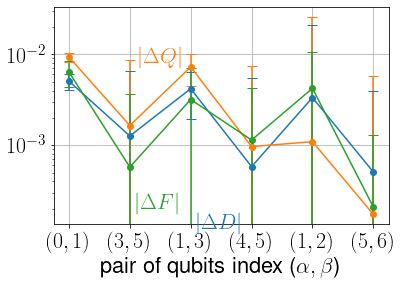

In [14]:
for j in [2,1,0]:
    plt.errorbar( range(6), error_mean[:,j], yerr=error_std[:,j], fmt='-o', capsize=5 )
plt.xticks( range(6), labels=[ '$(0,1)$', '$(3,5)$',  '$(1,3)$', '$(4,5)$', '$(1,2)$', '$(5,6)$' ]   )
plt.xlabel('pair of qubits index ($\\alpha,\\beta$)')
plt.grid()
plt.yscale('log')
plt.text( 1.1, 2e-4, '$|\\Delta F|$', color='tab:green' )
plt.text( 1.15, 8e-3, '$|\\Delta Q|$', color='tab:orange' )
plt.text( 2.1, 1.2e-4, '$|\\Delta D|$', color='tab:blue' )
plt.savefig('pa_vs_ind_double_quantities_v2.png', bbox_inches='tight', transparent=True )
plt.savefig('pa_vs_ind_double_quantities_v2.svg', bbox_inches='tight', transparent=True )

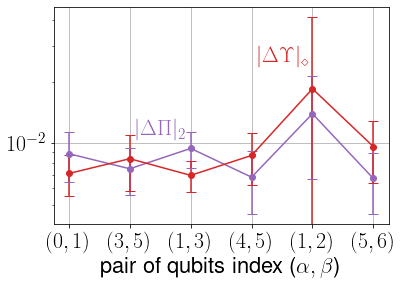

In [15]:
plt.errorbar( range(6), diamond_norms_mean[:,0], yerr=diamond_norms_std[:,0], fmt='-o', capsize=5, c = 'tab:purple' )
plt.errorbar( range(6), diamond_norms_mean[:,1], yerr=diamond_norms_std[:,1], fmt='-o', capsize=5, c = 'tab:red' )
plt.xticks( range(6), labels=[ '$(0,1)$', '$(3,5)$',  '$(1,3)$', '$(4,5)$', '$(1,2)$', '$(5,6)$' ]   )
plt.text( 1.1, 1.1e-2, '$|\\Delta\\Pi|_2$', color='tab:purple' )
plt.text( 3.1, 2.5e-2, '$|\\Delta\\Upsilon|_\diamond$', color='tab:red' )
plt.xlabel('pair of qubits index ($\\alpha,\\beta$)')
plt.grid()
plt.yscale('log')
plt.savefig('pa_vs_ind_double_error_v2.png', bbox_inches='tight', transparent=True )
plt.savefig('pa_vs_ind_double_error_v2.svg', bbox_inches='tight', transparent=True )

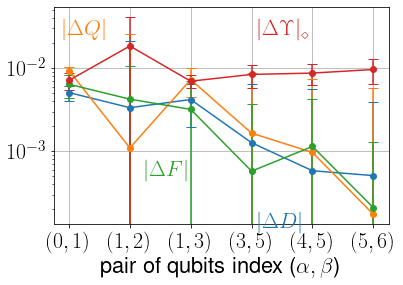

In [16]:
order = [0,4,2,1,3,5]
for j in [2,1,0]:
    plt.errorbar( range(6), error_mean[order,j], yerr=error_std[order,j], fmt='-o', capsize=5 )
plt.errorbar( range(6), diamond_norms_mean[order,1], yerr=diamond_norms_std[order,1], fmt='-o', capsize=5, c = 'tab:red' )
plt.xticks( range(6), labels=[ '$(0,1)$', '$(1,2)$',  '$(1,3)$', '$(3,5)$', '$(4,5)$', '$(5,6)$' ]   )
plt.xlabel('pair of qubits index ($\\alpha,\\beta$)')
plt.grid()
plt.yscale('log')
plt.text( 1.25, 5e-4, '$|\\Delta F|$', color='tab:green' )
plt.text( -0.1, 2.5e-2, '$|\\Delta Q|$', color='tab:orange' )
plt.text( 3.1, 1.2e-4, '$|\\Delta D|$', color='tab:blue' )
plt.text( 3.1, 2.5e-2, '$|\\Delta\\Upsilon|_\diamond$', color='tab:red' )
plt.savefig('pa_vs_ind_double_both_v2.png', bbox_inches='tight', transparent=True )
plt.savefig('pa_vs_ind_double_both_v2.svg', bbox_inches='tight', transparent=True )